Enter the session location: D:/MELA/Test Dataset SRT/20230308/SE_Lek1/


C:\Users\user\AppData\Local\Temp\ipykernel_16004\2045442615.py:204: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_day['File path'] = df_day['File path'].str.replace('\\', '/')
C:\Users\user\AppData\Local\Temp\ipykernel_16004\2045442615.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_16004\2045442615.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

17:36:37.062824
18:40:50.428953
Corresponding Frame for first_video_p1: 722
Corresponding Frame for first_video_p2: 226
Corresponding Frame for first_video_p3: 1
Corresponding Frame for last_video_p1: 5722
Corresponding Frame for last_video_p2: 5689
Corresponding Frame for last_video_p3: 2362


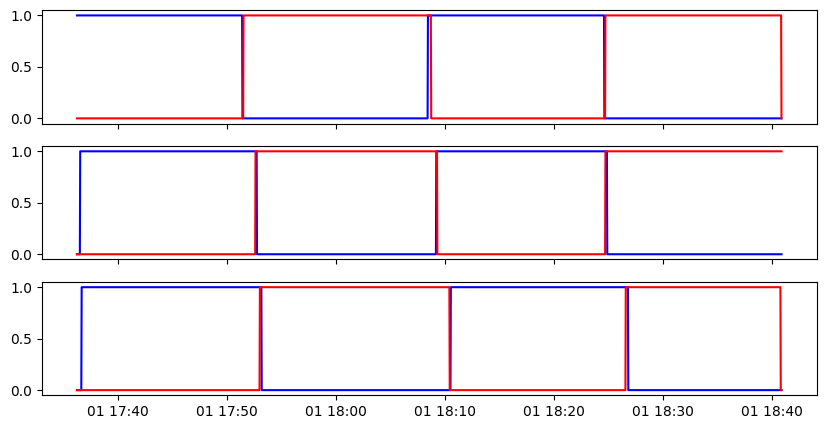

In [3]:
#Author : Dipin
#Function create csv after analysing a drone session

import re
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import datetime
from datetime import datetime, date






def main():


    # Ask the user for the session location
    session_location = input("Enter the session location: ")

    # Use glob to get a sorted list of folders
    folders = sorted(glob.glob(session_location + '/*'))

    df_day, df_plot, df_dict = dataframe_creation(folders)
    
    df_day = rearrange_columns(df_day)
    
    df_day, df_p1, df_p2, df_p3  = finding_missing_data(df_day)
    
    first_drone_P1, first_drone_P2, first_drone_P3, second_drone_P1, second_drone_P2, second_drone_P3 = drone_number(df_p1,
                                                                                                                     df_p2,
                                                                                                                     df_p3)
    
    df_day = sortieid(df_day,
                      first_drone_P1,
                      first_drone_P2,
                      first_drone_P3,
                      second_drone_P1,
                      second_drone_P2,
                      second_drone_P3)
    
    df_day, common_start_time, common_end_time = start_end_time(df_day, df_p1, df_p2, df_p3)
    
    first_video_p1, first_video_p2, first_video_p3, last_video_p1, last_video_p2, last_video_p3, fvp1, fvp2, fvp3, lvp1, lvp2, lvp3 = start_end_file(df_day,
                                                                                                                                                     df_p1,
                                                                                                                                                     df_p2,
                                                                                                                                                     df_p3, 
                                                                                                                                                     common_start_time,
                                                                                                                                                     common_end_time)
    
    df_day = start_end_frame(first_video_p1, 
                    first_video_p2,
                    first_video_p3,
                    last_video_p1,
                    last_video_p2,
                    last_video_p3,
                    df_dict,
                    common_start_time,
                    common_end_time,
                    df_p1,
                    df_p2,
                    df_p3,
                    df_day,
                    fvp1, fvp2, fvp3,
                    lvp1, lvp2, lvp3
                   )
    
    df_day = check_frame_drop(df_day)
    
    df_day,name = save_csv(df_day)
    
    save_txt(df_day, name)
    
    plot(df_plot)
    
  

    
    

    
    
    
def extract_data_from_srt(file_path):
    """
    Extracts data from a SubRip subtitle file.

    Args:
        file_path (str): The path to the subtitle file.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted data.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    # Use regular expressions to extract the frame number, timestamp, latitude, longitude, and altitude from each frame
    frames = re.findall(r'(\d+)\n.*?(\d{2}:\d{2}:\d{2},\d{3},\d{3}).*?\[latitude:\s*([-+]?\d+\.\d+)\]\s*\[longitude:\s*([-+]?\d+\.\d+)\]\s*\[altitude:\s*([-+]?\d+\.\d+)\]', content, re.DOTALL)
    frame_times = re.findall(r'\d{2}:\d{2}:\d{2},\d{3} --> (\d{2}:\d{2}:\d{2},\d{3})', content)
    
    # Convert the extracted data into a list of dictionaries, where each dictionary represents one frame
    results = [{'frame': int(frame), 'timestamp': str(timestamp), 'latitude': float(latitude), 'longitude': float(longitude), 'altitude': float(altitude), 'frame_time': frame_time} for (frame, timestamp, latitude, longitude, altitude), frame_time in zip(frames, frame_times)]
   
    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(results)



def geodist(coord1, coord2_lat, coord2_long):
    """
    Computes the geodesic distance between two geographic coordinates.

    Args:
        coord1 (tuple): A tuple representing the first coordinate, in the format (latitude, longitude).
        coord2_lat (float): The latitude of the second coordinate.
        coord2_long (float): The longitude of the second coordinate.

    Returns:
        float: The geodesic distance between the two coordinates, in metres.
    """
    return distance.distance(coord1, (coord2_lat, coord2_long)).m


def dataframe_creation(folders):
    """
    Takes data drom the srt files and convert them to a data frame
    
    Args:
        folders: Location of the files
    
    Return:
        df_day: data frame creted for the whole session
        df_plot: data frame to draw the graph at the end
        df_dict: dictionary that contain data frame of every single srt file
        
    
    """
    
    # Create empty lists to store dataframes and results
    df_list = []
    dist_max = []
    drift_status = []
    height_status = []
    df_dict = {}
    drift_thresh=5
    height_thresh=7
    
    for folder in folders:
        files = sorted(glob.glob(folder + '/*.SRT'))
        
        for file in files:
            df_rec = extract_data_from_srt(file)
            
            # Working on altitude to find relay
            df_rec['normal_altitude'] = 80.0
            df_rec['height_difference'] = df_rec['altitude'] - df_rec['normal_altitude']
            
            if df_rec['height_difference'].max() > height_thresh:
                height_status.append(1)
            else:
                height_status.append(0)
            
            # Working on drift
            coord1 = (df_rec['latitude'].mean(), df_rec['longitude'].mean())
            df_rec['distance'] = df_rec.apply(lambda row: geodist(coord1, row.latitude, row.longitude), axis=1)
            
            if df_rec['distance'].max() > drift_thresh:
                drift_status.append(1)
            else:
                drift_status.append(0)
            
            start_ts = df_rec['timestamp'].iloc[0]
            end_ts = df_rec['timestamp'].iloc[-1]
            
            df_list.append({
                'folder': folder[-4:],
                'Video_ID': file[-12:-4],
                'start_timestamp': start_ts,
                'end_timestamp': end_ts,
                'File path': folder,
                'minimum height': df_rec['altitude'].min(),
                'maximum drift': df_rec['distance'].max(),
                'Total frames': df_rec['frame'].max(),
                'Frame time': df_rec['frame_time'].max(),
                'maximum height': df_rec['altitude'].max()
            })
            
            df_dict[folder[-4:] + '_' + file[-12:-4]] = df_rec.copy()
    
    df_day = pd.DataFrame(df_list)
    df_day['drift_status'] = drift_status
    df_day['Relay video'] = height_status
    
    def Frame_time_to_seconds(time_str):
        time_obj = datetime.strptime(time_str, '%H:%M:%S,%f')
        return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1000000
    
    df_day['Frame time'] = df_day['Frame time'].apply(Frame_time_to_seconds)
    df_plot = df_day.copy()
    
    return df_day, df_plot, df_dict




def rearrange_columns(df_day):
    
    """
    Rearranges and splits certain columns
    Args:
        df_day : dataframe of the session
        
    Return:
        df_day : Updated dataframe of the session
     
    """
    
    # Replace backslashes with forward slashes in the 'File path' column
    df_day['File path'] = df_day['File path'].str.replace('\\', '/')
    
    # Create a new column 'Unique name' in df_day
    df_day['Unique name'] = df_day['File path'].str.split('/').str[-3] + '_' + df_day['File path'].str.split('/').str[-2] + '_' + df_day['folder'] + '_' + df_day['Video_ID']
    
    # Extract first 2 letters into 'position' column
    df_day['position'] = df_day['folder'].str[:2]
    
    # Extract last 2 letters into 'drone' column
    df_day['drone'] = df_day['folder'].str[2:]
    
    # Rearrange the columns to match the desired position
    df_day = df_day[['Video_ID', 'position', 'drone', 'start_timestamp', 'end_timestamp', 'Relay video', 'drift_status', 'maximum drift', 'maximum height', 'minimum height', 'File path', 'Unique name', 'Total frames', 'Frame time']]
    
    return df_day

def finding_missing_data(df_day):
    
    """
    if the time difference between subsequent video files is between 1s and 10 minutes, It is reported as a miss click
    
        Args:
            df_day : dataframe of the session
        
        Return:
            df_day : Updated dataframe of the session
            df_p1: dataframe of the session from position 1
            df_p2: dataframe of the session from position 2
            df_p3: dataframe of the session from position 3

    """
    
    positions = ['P1', 'P2', 'P3']

    dfs = {}

    for position in positions:
        df_p = df_day[df_day['position'] == position]

        # Remove the comma before microseconds
        df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
        df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

        # Convert the timestamp columns to datetime type
        df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
        df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

        # Shift the values in the "end_timestamp" column by one row
        df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

        # Calculate the time difference and store the absolute value in the "end_start_diff" column
        df_p['end_start_diff'] = (df_p['previous_end_timestamp'] - df_p['start_timestamp']).dt.total_seconds().abs()

        # Remove the unnecessary column
        df_p = df_p.drop('previous_end_timestamp', axis=1)

        # To remove NAN of the last row
        df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

        # Create the 'error' column and initialize it with 0
        df_p['error'] = 0

        # Set the 'error' values based on the condition
        df_p.loc[(df_p['end_start_diff'] > 1) & (df_p['end_start_diff'] < 600), 'error'] = 1

        # Convert the "error" column to integer type
        df_p['error'] = df_p['error'].astype(int)

        # Merge the data from error and Miss click

        df_day.loc[df_p.index, 'Miss click'] = df_p['error'].values

        # Remove the dates from the timestamp columns
        df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
        df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

        # Store the DataFrame in the dictionary
        dfs[position] = df_p.copy()

    # Create separate DataFrames for P1, P2, and P3
    df_p1 = dfs['P1']
    df_p2 = dfs['P2']
    df_p3 = dfs['P3']
    
    return df_day, df_p1, df_p2, df_p3

def drone_number(df_p1, df_p2, df_p3):
    """
    Drones are numbered depending on the starting time of the drones in each position. The other drone is marked as 
    the second drone
    
    Args:
        df_p1: dataframe of the session from position 1
        df_p2: dataframe of the session from position 2
        df_p3: dataframe of the session from position 3
        
    Return:
        first_drone_P1, first_drone_P2, first_drone_P3 : First drone that flew at each position
        second_drone_P1, second_drone_P2, second_drone_P3 :Second frone that flew at each position
    
    """
    
    dfs = [df_p1, df_p2, df_p3]

    # Lists to store first and second drones for each position
    first_drones = []
    second_drones = []

    # Iterate through each DataFrame for P1, P2, and P3
    for i, df_p in enumerate(dfs):
        # Find the row with the lowest value in the 'start_timestamp' column
        lowest_start_time = df_p['start_timestamp'].min()
        lowest_start_row = df_p[df_p['start_timestamp'] == lowest_start_time]

        # Extract the value in the 'drone' column from the lowest start time row
        first_drone = lowest_start_row['drone'].values[0]
        first_drones.append(first_drone)

        # Find the second drone for each position
        second_drone = df_p[df_p['drone'] != first_drone]['drone'].values[0]
        second_drones.append(second_drone)

    # Store the first drones for P1, P2, and P3 as separate variables
    first_drone_P1 = first_drones[0]
    first_drone_P2 = first_drones[1]
    first_drone_P3 = first_drones[2]

    # Store the second drones for P1, P2, and P3 as separate variables
    second_drone_P1 = second_drones[0]
    second_drone_P2 = second_drones[1]
    second_drone_P3 = second_drones[2]
    
    return first_drone_P1, first_drone_P2, first_drone_P3, second_drone_P1, second_drone_P2, second_drone_P3


def sortieid(df_day, first_drone_P1, first_drone_P2, first_drone_P3, second_drone_P1, second_drone_P2, second_drone_P3):
    
    """
    Column created for sortie id by considering the drone number and difference between the start and end time of consecutive
    drones

    Args:
        df_day : dataframe of the session
        first_drone_P1, first_drone_P2, first_drone_P3 : First drone that flew at each position
        second_drone_P1, second_drone_P2, second_drone_P3 :Second frone that flew at each position
        
    Return: 
        df_day : Updated dataframe of the session 
    
    """
    # For the first set of drones
    positions = ['P1', 'P2', 'P3']
    drones = [first_drone_P1, first_drone_P2, first_drone_P3]

    dfs = {}

    for position in positions:
        for drone in drones:
            df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]

            if not df_p.empty:  # Check if the DataFrame is not empty
                # Rearrange df_p in ascending order of the data in the start_timestamp column
                df_p = df_p.sort_values(by='start_timestamp', ascending=True)

                # Remove the comma before microseconds
                df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
                df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

                # Convert the timestamp columns to datetime type
                df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
                df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

                # Shift the values in the "start_timestamp" column by one row
                df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

                # Calculate the time difference and store the absolute value in the "end_start_diff" column
                df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

                # Remove the unnecessary column
                df_p = df_p.drop('previous_end_timestamp', axis=1)

                # To remove NAN of the last row
                df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

                # FINDING THE SORTIE NUMBER
                # Initialize the sortie column with 1
                df_p['sortie'] = 0

                # Set the sortie values based on the condition
                sortie_count = 0
                for index, row in df_p.iterrows():
                    if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                        sortie_count += 2
                    df_p.at[index, 'sortie'] = sortie_count + 1


                # Convert the "sortie" column to integer type
                df_p['sortie'] = df_p['sortie'].astype(int)

                # Merge the data from "sortie" column of df_p to "flight number" column of df_day
                df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

                # Remove the dates from the timestamp columns
                df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
                df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

                # Store the DataFrame in the dictionary
                dfs[(position, drone)] = df_p.copy()

    #For the second set of drones
    positions = ['P1', 'P2', 'P3']
    drones = [second_drone_P1, second_drone_P2, second_drone_P3]

    dfs = {}

    for position in positions:
        for drone in drones:
            df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]

            if not df_p.empty:  # Check if the DataFrame is not empty
                # Rearrange df_p in ascending order of the data in the start_timestamp column
                df_p = df_p.sort_values(by='start_timestamp', ascending=True)

                # Remove the comma before microseconds
                df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
                df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

                # Convert the timestamp columns to datetime type
                df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
                df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

                # Shift the values in the "start_timestamp" column by one row
                df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

                # Calculate the time difference and store the absolute value in the "end_start_diff" column
                df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

                # Remove the unnecessary column
                df_p = df_p.drop('previous_end_timestamp', axis=1)

                # To remove NAN of the last row
                df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

                # FINDING THE SORTIE NUMBER
                # Initialize the sortie column with 1
                df_p['sortie'] = 0

                # Set the sortie values based on the condition
                sortie_count = 0
                for index, row in df_p.iterrows():
                    if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                        sortie_count += 2
                    df_p.at[index, 'sortie'] = sortie_count + 2


                # Convert the "sortie" column to integer type
                df_p['sortie'] = df_p['sortie'].astype(int)

                # Merge the data from "sortie" column of df_p to "flight number" column of df_day
                df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

                # Remove the dates from the timestamp columns
                df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
                df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

                # Store the DataFrame in the dictionary
                dfs[(position, drone)] = df_p.copy()                
    return df_day
                
def start_end_time(df_day, df_p1, df_p2, df_p3):
    """
    calculates the start time and end time by comparing the lowest and highest value in the start and end time of drones at each 
    positions
    
    Args:
        df_day : dataframe of the session
        df_p1: dataframe of the session from position 1
        df_p2: dataframe of the session from position 2
        df_p3: dataframe of the session from position 3
    
    Return:
        df_day : Updated dataframe of the session
        common_start_time: Global start time of the session
        common_end_time  : Global end time of the session
        
    
    """
    
    #FINDING COMMON START AND END TIME POINT AND PRINTING IN CSV
    # Create a list to hold the start times of all three DataFrames
    start_times = []

    # Loop through each DataFrame and get the maximum value of the first row's start_timestamp column
    for df in [df_p1, df_p2, df_p3]:
        min_start_time = df['start_timestamp'].min()
        start_times.append(min_start_time)


    # Find the maximum value among the three common start times
    common_start_time = max(start_times)

    # Create a list to hold the end times of all three DataFrames
    end_times = []

    # Loop through each DataFrame and get the minimum value of the last row's end_timestamp column
    for df in [df_p1, df_p2, df_p3]:
        max_end_time = df['end_timestamp'].max()
        end_times.append(max_end_time)

    # Find the minimum value among the three common end times
    common_end_time = min(end_times)

    # Assign values to the first row of the new columns
    df_day.loc[0, 'Global start time'] = common_start_time
    df_day.loc[0, 'Global end time'] = common_end_time

    #Assign 0 to rest of the rows
    df_day['Global start time'].iloc[1:] = pd.to_datetime(0)
    df_day['Global end time'].iloc[1:] = pd.to_datetime(0)

    # Convert 'Common start time' and 'Common end time' columns to datetime
    df_day['Global start time'] = pd.to_datetime(df_day['Global start time'].astype(str))
    df_day['Global end time'] = pd.to_datetime(df_day['Global end time'].astype(str))
    df_day.loc[1:, 'Global start time'] = pd.to_datetime(0)
    df_day.loc[1:, 'Global end time'] = pd.to_datetime(0)

    # Remove date part from 'Common start time' column and 'Common end time' column where value is not 0
    df_day['Global start time'] = df_day['Global start time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)
    df_day['Global end time'] = df_day['Global end time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)

    #TO MAKE SURE CSV FILE IS NOT ROUNDED UP FOR COMMON START AND END TIME

    # Function to format time strings to "hours:minutes:seconds,microseconds" format
    def format_common_time(time_obj):
        time_str = str(time_obj)  # Convert datetime.time object to string
        hours, minutes, seconds = time_str.split(":")

        # Split the seconds part into seconds and microseconds
        seconds_part = seconds.split(".")
        seconds = seconds_part[0]
        microseconds = seconds_part[1] if len(seconds_part) > 1 else '000000'
        microseconds = microseconds.ljust(6, "0")  # Pad zeros if needed

        formatted_time = f"{hours}:{minutes}:{seconds},{microseconds}"
        return formatted_time

    # Format the time values in the columns
    df_day['Global start time'] = df_day['Global start time'].apply(format_common_time)
    df_day['Global end time'] = df_day['Global end time'].apply(format_common_time)


    # Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common start time' column
    df_day['Global start time'].iloc[1:] = '0'

    # Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common end time' column
    df_day['Global end time'].iloc[1:] = '0'


    print(common_start_time)
    print(common_end_time)
    
    return df_day, common_start_time, common_end_time



def start_end_file(df_day, df_p1, df_p2, df_p3, common_start_time, common_end_time ):
    
    """
    Finds the start and end srt file by finding which srt file has the global start and end time  
    
        Args:
            df_day : dataframe of the session
            df_p1: dataframe of the session from position 1
            df_p2: dataframe of the session from position 2
            df_p3: dataframe of the session from position 3
            common_start_time: Global start time of the session
            common_end_time  : Global end time of the session
        
        
        Return:
            first_video_p1, first_video_p2, first_video_p3,: video names used later to call the files from the df_dict
            last_video_p1, last_video_p2, last_video_p3: video names used later to call the files from the df_dict
            fvp1, fvp2, fvp3 : First video of the session from each location
            lvp1, lvp2, lvp3 : Last video of the session from each location
            
            
    """
    # Assuming 'X' contains the time in the format "17:01:43.728497"
    X = common_start_time

    # Convert 'X' to a pandas Timestamp object for comparison
    common_start_time_timestamp = pd.to_datetime(X, format="%H:%M:%S.%f")

    # Create a dictionary to store the dataframes and their corresponding variables
    dataframes = {'df_p1': df_p1.copy(), 'df_p2': df_p2.copy(), 'df_p3': df_p3.copy()}

    # Create variables to store the first video IDs
    first_video_p1 = None
    first_video_p2 = None
    first_video_p3 = None

    # Iterate over the dataframes
    for df_name, df in dataframes.items():
        # Convert the 'start_timestamp' and 'end_timestamp' columns in the current dataframe to pandas Timestamp objects
        df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format="%H:%M:%S.%f")
        df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format="%H:%M:%S.%f")

        # Find the row where 'common_start_time_timestamp' falls within the 'start_timestamp' and 'end_timestamp' interval
        selected_row = df[(df['start_timestamp'] <= common_start_time_timestamp) & (df['end_timestamp'] >= common_start_time_timestamp)]

        # Check if any row was found and store the corresponding Video_ID in the appropriate variable
        if not selected_row.empty:
            if df_name == 'df_p1':
                first_video_p1 = "P1" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                fvp1 = selected_row['Video_ID'].values[0]
            elif df_name == 'df_p2':
                first_video_p2 = "P2" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                fvp2 = selected_row['Video_ID'].values[0]
            elif df_name == 'df_p3':
                first_video_p3 = "P3" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                fvp3 = selected_row['Video_ID'].values[0]

    #Finding the file name that contain the global end time


    X = common_end_time

    # Convert 'X' to a pandas Timestamp object for comparison
    common_end_time_timestamp = pd.to_datetime(X, format="%H:%M:%S.%f")

    # Create a dictionary to store the dataframes and their corresponding variables
    dataframes = {'df_p1': df_p1.copy(), 'df_p2': df_p2.copy(), 'df_p3': df_p3.copy()}

    # Create variables to store the first video IDs
    last_video_p1 = None
    last_video_p2 = None
    last_video_p3 = None

    # Iterate over the dataframes
    for df_name, df in dataframes.items():
        # Convert the 'start_timestamp' and 'end_timestamp' columns in the current dataframe to pandas Timestamp objects
        df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format="%H:%M:%S.%f")
        df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format="%H:%M:%S.%f")

        # Find the row where 'common_start_time_timestamp' falls within the 'start_timestamp' and 'end_timestamp' interval
        selected_row = df[(df['start_timestamp'] <= common_end_time_timestamp) & (df['end_timestamp'] >= common_end_time_timestamp)]

        # Check if any row was found and store the corresponding Video_ID in the appropriate variable
        if not selected_row.empty:
            if df_name == 'df_p1':
                last_video_p1 ="P1" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                lvp1 = selected_row['Video_ID'].values[0]
            elif df_name == 'df_p2':
                last_video_p2 = "P2" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                lvp2 = selected_row['Video_ID'].values[0]
            elif df_name == 'df_p3':
                last_video_p3 ="P3" + selected_row['drone'].values[0]+"_"+selected_row['Video_ID'].values[0]
                lvp3 = selected_row['Video_ID'].values[0]


    
    return first_video_p1, first_video_p2, first_video_p3, last_video_p1, last_video_p2, last_video_p3, fvp1, fvp2, fvp3, lvp1, lvp2, lvp3

def start_end_frame(first_video_p1, 
                    first_video_p2,
                    first_video_p3,
                    last_video_p1,
                    last_video_p2,
                    last_video_p3,
                    df_dict,
                    common_start_time,
                    common_end_time,
                    df_p1,
                    df_p2,
                    df_p3,
                    df_day,fvp1, fvp2, fvp3, lvp1, lvp2, lvp3
                    
                   ):
    """
    Finds the exact frame of the global start and end time for each position
    
    Args:
        df_day : dataframe of the session
        df_p1: dataframe of the session from position 1
        df_p2: dataframe of the session from position 2
        df_p3: dataframe of the session from position 3
        common_start_time: Global start time of the session
        common_end_time  : Global end time of the session
        first_video_p1, first_video_p2, first_video_p3,: video names used to call the the dataframe of
        the first video files from the df_dict of each location
        last_video_p1, last_video_p2, last_video_p3: video names used to call the the dataframe of
        the last video files from the df_dict of each location
        fvp1, fvp2, fvp3 : First video of the session from each location
        lvp1, lvp2, lvp3 : Last video of the session from each location
        
    Return:
        df_day : Updated dataframe of the session
"""
 

    #FOR FINDING THE FIRST FRAMES
    import datetime

    #FOR FINDING THE FIRST FRAMES

    from datetime import datetime, date, time
    # List of first_video_p values
    first_video_p_list = [first_video_p1, first_video_p2, first_video_p3]

    # Dictionary to store corresponding_frame for each first_video_p
    corresponding_frame_dict = {}

    # Loop through each first_video_p value
    for first_video_p in first_video_p_list:
        data_frame = df_dict.get(first_video_p)
        df_fr = data_frame.copy()


        df_fr['timestamp'] = df_fr['timestamp'].str.replace(',', '')
        # Convert the timestamp columns to datetime type
        df_fr['timestamp'] = pd.to_datetime(df_fr['timestamp'], format='%H:%M:%S%f')
        # Remove the dates from the timestamp columns
        df_fr['timestamp'] = df_fr['timestamp'].dt.time


        def calculate_time_difference(row):
            common_datetime = datetime.combine(date.today(), common_start_time)

            timestamp_datetime = datetime.combine(date.today(), row['timestamp'])
            time_difference = (timestamp_datetime - common_datetime).total_seconds()
            return time_difference


        df_fr['time_diff'] = df_fr.apply(calculate_time_difference, axis=1)


        positive_time_diff_df = df_fr[df_fr['time_diff'] >= 0]

        # Step 5: Find the row with the smallest positive time difference
        min_positive_time_diff_row = positive_time_diff_df.loc[positive_time_diff_df['time_diff'].idxmin()]

        # Step 6: Get the corresponding frame value
        corresponding_frame = min_positive_time_diff_row['frame']

        # Save corresponding_frame in the dictionary for the current first_video_p
        corresponding_frame_dict[first_video_p] = corresponding_frame

    # Extract corresponding_frame values from the dictionary and store in separate variables
    first_frame_p1 = corresponding_frame_dict.get(first_video_p1)
    first_frame_p2 = corresponding_frame_dict.get(first_video_p2)
    first_frame_p3 = corresponding_frame_dict.get(first_video_p3)

    # Print the corresponding_frame values for each first_video_p
    print("Corresponding Frame for first_video_p1:", first_frame_p1)
    print("Corresponding Frame for first_video_p2:", first_frame_p2)
    print("Corresponding Frame for first_video_p3:", first_frame_p3)
    
    #FOR FINDING THE LAST FRAMES# List of last_video_p values
        #FOR FINDING THE LAST FRAMES# List of last_video_p values
    from datetime import datetime, date, time
    # List of last_video_p values
    last_video_p_list = [last_video_p1, last_video_p2, last_video_p3]

    # Dictionary to store corresponding_frame for each first_video_p
    corresponding_frame_dict = {}

    # Loop through each first_video_p value
    for last_video_p in last_video_p_list:
        data_frame = df_dict.get(last_video_p)
        df_fr = data_frame.copy()


        df_fr['timestamp'] = df_fr['timestamp'].str.replace(',', '')
        # Convert the timestamp columns to datetime type
        df_fr['timestamp'] = pd.to_datetime(df_fr['timestamp'], format='%H:%M:%S%f')
        # Remove the dates from the timestamp columns
        df_fr['timestamp'] = df_fr['timestamp'].dt.time

        def calculate_time_difference(row):
            common_datetime = datetime.combine(date.today(), common_end_time)

            timestamp_datetime = datetime.combine(date.today(), row['timestamp'])
            time_difference = (common_datetime - timestamp_datetime).total_seconds()
            return time_difference

        df_fr['time_diff'] = df_fr.apply(calculate_time_difference, axis=1)
        positive_time_diff_df = df_fr[df_fr['time_diff'] >= 0]

        # Step 5: Find the row with the smallest positive time difference
        min_positive_time_diff_row = positive_time_diff_df.loc[positive_time_diff_df['time_diff'].idxmin()]

        # Step 6: Get the corresponding frame value
        corresponding_frame = min_positive_time_diff_row['frame']

        # Save corresponding_frame in the dictionary for the current first_video_p
        corresponding_frame_dict[last_video_p] = corresponding_frame

    # Extract corresponding_frame values from the dictionary and store in separate variables
    last_frame_p1 = corresponding_frame_dict.get(last_video_p1)
    last_frame_p2 = corresponding_frame_dict.get(last_video_p2)
    last_frame_p3 = corresponding_frame_dict.get(last_video_p3)

    # Print the corresponding_frame values for each first_video_p
    print("Corresponding Frame for last_video_p1:", last_frame_p1)
    print("Corresponding Frame for last_video_p2:", last_frame_p2)
    print("Corresponding Frame for last_video_p3:", last_frame_p3)

    #ASSIGNING STARTING AND ENDING FRAMES TO THE CSV FILE

    positions = ['P1', 'P2', 'P3']

    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P1'
    df_p1 = df_day[df_day['position'] == 'P1'].copy()
    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P2'
    df_p2 = df_day[df_day['position'] == 'P2'].copy()
    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P3'
    df_p3 = df_day[df_day['position'] == 'P3'].copy()

    # Initialize 'start_frame' column to 0 for all DataFrames
    for df_position in [df_p1, df_p2, df_p3]:
        df_position['start_frame'] = 0

    # Set 'start_frame' for specific 'Video_ID's in each DataFrame
    df_p1.loc[df_p1[df_p1['Video_ID'] == fvp1].index, 'start_frame'] = first_frame_p1
    df_p2.loc[df_p2[df_p2['Video_ID'] == fvp2].index, 'start_frame'] = first_frame_p2
    df_p3.loc[df_p3[df_p3['Video_ID'] == fvp3].index, 'start_frame'] = first_frame_p3

    # Iterate through positions and update the main dataframe 'df_day'
    for position, df_position in zip(positions, [df_p1, df_p2, df_p3]):
        # Update the main dataframe 'df_day' with the changes made in the current position's DataFrame
        df_day.loc[df_position.index, 'Start Frame'] = df_position['start_frame'].values


    positions = ['P1', 'P2', 'P3']

    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P1'
    df_p1 = df_day[df_day['position'] == 'P1'].copy()
    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P2'
    df_p2 = df_day[df_day['position'] == 'P2'].copy()
    # Create a new DataFrame df_p1 with rows where 'Video_ID' is 'P3'
    df_p3 = df_day[df_day['position'] == 'P3'].copy()

    # Initialize 'start_frame' column to 0 for all DataFrames
    for df_position in [df_p1, df_p2, df_p3]:
        df_position['end_frame'] = 0

    # Set 'start_frame' for specific 'Video_ID's in each DataFrame
    df_p1.loc[df_p1[df_p1['Video_ID'] == lvp1].index, 'end_frame'] = last_frame_p1
    df_p2.loc[df_p2[df_p2['Video_ID'] == lvp2].index, 'end_frame'] = last_frame_p2
    df_p3.loc[df_p3[df_p3['Video_ID'] == lvp3].index, 'end_frame'] = last_frame_p3

    # Iterate through positions and update the main dataframe 'df_day'
    for position, df_position in zip(positions, [df_p1, df_p2, df_p3]):
        # Update the main dataframe 'df_day' with the changes made in the current position's DataFrame
        df_day.loc[df_position.index, 'End Frame'] = df_position['end_frame'].values
    
    return df_day


def check_frame_drop(df_day):
    """
    Compares the frame extracted from the srt file to the frames clalculated by multiplying flight time of each
    flight with 30 (30fps)
    
    Args:
        df_day : dataframe of the session
        
     Return:
         df_day : Updated dataframe of the session
         
         
    """
    
    #Checking for frame drops
    df_x = df_day.copy()

    # Remove the comma before microseconds
    df_x['start_timestamp'] = df_x['start_timestamp'].str.replace(',', '')
    df_x['end_timestamp'] = df_x['end_timestamp'].str.replace(',', '')

        # Convert the timestamp columns to datetime type
    df_x['start_timestamp'] = pd.to_datetime(df_x['start_timestamp'], format='%H:%M:%S%f')
    df_x['end_timestamp'] = pd.to_datetime(df_x['end_timestamp'], format='%H:%M:%S%f')

    # Calculate the time difference and store the absolute value in the "end_start_diff" column
    df_x['Global TOF'] = (df_x['end_timestamp'] - df_x['start_timestamp']).dt.total_seconds().abs()
    #30 fps video
    df_x['Required frames'] = df_x['Global TOF'] * 30

    # Create the 'Frame drop' column and initialize it with 0
    df_x['Frame drop'] = 0

    # Set the 'frame drop' values based on the condition
    df_x.loc[(df_x['Required frames'] - df_x['Total frames'] > 5) , 'Frame drop'] = 1

    # Merge the data
    df_day.loc[df_x.index, 'Frame drop'] = df_x['Frame drop'].values
    df_day.loc[df_x.index, 'Global TOF'] = df_x['Global TOF'].values
    df_day.loc[df_x.index, 'Required frames'] = df_x['Required frames'].values
    
    return df_day


def save_csv(df_day):

    # Rearrange the columns to match the desired position
    df_day = df_day[['Unique name', 'Video_ID','position', 'drone','Total frames', 'start_timestamp', 'end_timestamp', 'flight number', 'Relay video',  'maximum drift'  , 'drift_status', 'Miss click', 'maximum height', 'minimum height','Global start time','Global end time', 'Start Frame', 'End Frame','Frame drop','Frame time', 'Global TOF','Required frames', 'File path']]

    
    input_string = df_day['Unique name'][0]  # Replace with the actual input string
    name = '_'.join(input_string.split('_')[:3])


    df_day.to_csv(f'{name}.csv', index=False) # Set index=False if you don't want to save the index column
    return df_day, name

def save_txt(df_day, name):
    #CREATES TXT FILE IF ANY ERROR FOUND IN DRIFT OR MISS CLICK
   
    # Filter rows where 'drift_status' or 'Miss click' is equal to 1
    filtered_df = df_day[(df_day['drift_status'] == 1) | (df_day['Miss click'] == 1) | (df_day['minimum height'] < 78) | (df_day['Frame drop'] == 1)]

    # If there are any rows with 'drift_status' or 'Miss click' equal to 1, create the text file
    if not filtered_df.empty:
        file_name = f"{name}_summary.txt"

        # Create the text file and write the content
        with open(file_name, 'w') as f:
            f.write("Summary of the errors\n")
            for index, row in filtered_df.iterrows():
                drift = row['maximum drift']
                video_id = row['Unique name']
                height = row['minimum height']
                if row['drift_status'] == 1:
                    f.write(f"Drift found at the {video_id} of value {drift}m\n")
                if row['Miss click'] == 1:
                    f.write(f"Miss click found at the {video_id}\n")
                if row['minimum height'] < 78:
                    f.write(f"Drone flew below 78m at the {video_id}, height = {height} m \n")
                if row['Frame drop'] == 1:
                    f.write(f"Frame drop at the {video_id}\n") 


def plot(df_plot):
    
    # Convert timestamps to python datetime %H:%M:%S,%f format
    df_plot['start_timestamp'] = df_plot['start_timestamp'].str[:-4] + df_plot['start_timestamp'].str[-3:]
    df_plot['end_timestamp'] = df_plot['end_timestamp'].str[:-4] + df_plot['end_timestamp'].str[-3:]

    df_plot['start_timestamp'] = pd.to_datetime(df_plot['start_timestamp'], format= '%H:%M:%S,%f')#.dt.time
    df_plot['end_timestamp'] = pd.to_datetime(df_plot['end_timestamp'], format='%H:%M:%S,%f')#.dt.time

    # Generate a range of timestamps using the minimum start timestamp and maximum end timestamp, with a 2-second frequency
    x_values = pd.date_range(df_plot['start_timestamp'].min(), df_plot['end_timestamp'].max(), freq='2S')

    # Initialize an empty list to store data for each drone at each timestamp
    drone_id = []

    # Iterate over each timestamp in the x_values range
    for x in x_values:
        # For each drone, count the number of entries where the start_timestamp is less than or equal to the current timestamp, 
        # the end_timestamp is greater than the current timestamp, and the folder contains the drone ID
        drone_id.append([
            x, 
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D1')),:]),
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D2')),:]),
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D3')),:]),
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D4')),:]),
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D5')),:]),
            len(df_plot.loc[(df_plot['start_timestamp'] <= x) & (df_plot['end_timestamp'] > x) & (df_plot['folder'].str.contains('D6')),:])
        ])

    # Create a pandas DataFrame from the drone_id list
    t = pd.DataFrame(drone_id)

    # Create a figure with 3 subplots and a shared x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

    # Plot data of drones D1 and D2 on position P1
    ax1.plot(t[0], t[1], c='blue')
    ax1.plot(t[0], t[2], c='red')

    # Plot data of drones D3 and D4 on position P2
    ax2.plot(t[0], t[3], c='blue')
    ax2.plot(t[0], t[4], c='red')

    # Plot data of drones D5 and D6 on position P3
    ax3.plot(t[0], t[5], c='blue')
    ax3.plot(t[0], t[6], c='red')

    # Display the plot
    plt.show()   



if __name__ == "__main__":
    main()

In [ ]:
D:/MELA/Test Dataset SRT/20230308/SE_Lek1/